In [23]:
#@title Delete Existing FIles If any
import shutil
import os

# Define paths to augmented datasets and validation results folders
augmented_folder = '/content/Output'
validation_folder = '/content/Validation Results/'
histograms_folder = '/content/Validation Results/Histograms'
metrics_folder = '/content/Validation Results/Metrics'
time_series_plots_folder = '/content/Validation Results/Time_Series_Plots'

# Delete existing augmented datasets
if os.path.exists(augmented_folder):
    shutil.rmtree(augmented_folder)
    print(f"Deleted existing augmented datasets in {augmented_folder}")

# Delete existing validation results and subfolders
if os.path.exists(validation_folder):
    shutil.rmtree(validation_folder)
    print(f"Deleted existing validation results in {validation_folder}")

# Recreate empty folders for augmented datasets and validation results
os.makedirs(augmented_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)
os.makedirs(histograms_folder, exist_ok=True)
os.makedirs(metrics_folder, exist_ok=True)
os.makedirs(time_series_plots_folder, exist_ok=True)

Deleted existing augmented datasets in /content/Output
Deleted existing validation results in /content/Validation Results/


In [24]:
#@title Code to Create 5 Synthetic Datasets for each Standard Drive Cycle
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Helper functions for augmentation and validation

def detect_pattern(speed_series):
    patterns = []
    for i in range(1, len(speed_series)):
        if speed_series[i] > speed_series[i-1]:
            patterns.append('accelerating')
        elif speed_series[i] < speed_series[i-1]:
            patterns.append('decelerating')
        else:
            patterns.append('idling')
    return patterns

def add_noise_with_limit(speed, patterns, noise_range=3, decimal_places=1):
    synthetic_speed = speed.copy()

    for i in range(len(speed)):
        # If the speed is 0 at any point, keep the speed as 0 in the synthetic dataset
        if speed[i] == 0:
            synthetic_speed[i] = 0
        else:
            # Add noise based on the driving pattern
            if patterns[i-1] == 'accelerating':
                noise = np.round(np.random.uniform(0, noise_range), decimals=decimal_places)
            elif patterns[i-1] == 'decelerating':
                noise = np.round(np.random.uniform(-noise_range, 0), decimals=decimal_places)
            else:
                noise = np.round(np.random.uniform(-1, 1), decimals=decimal_places)  # Less noise during idling

            # Apply the noise
            synthetic_speed[i] += noise

        # Ensure no negative speed values
        if synthetic_speed[i] < 0:
            synthetic_speed[i] = 0

    return synthetic_speed

# Load all standard datasets and calculate total duration
input_folder = '/content/Input'  # Replace with the folder containing all standard datasets
all_files = [f for f in os.listdir(input_folder) if f.endswith('.xlsx')]

total_seconds = 0

if len(all_files) > 0:
    for file_name in all_files:
        file_path = os.path.join(input_folder, file_name)
        data = pd.read_excel(file_path)
        total_seconds += data['Test Time, secs'].iloc[-1]  # Assuming time is cumulative in each file

    total_hours = total_seconds / 3600
    print(f"Total duration of standard datasets: {total_hours:.2f} hours")

    # Augmentation Loop: Generate 5 augmented datasets for each standard dataset
    for file_name in all_files:
        file_path = os.path.join(input_folder, file_name)
        original_data = pd.read_excel(file_path)

        # Extract time and speed columns
        time = original_data['Test Time, secs']
        speed = original_data['Target Speed, mph']

        # Detect patterns of acceleration, deceleration, and idling
        patterns = detect_pattern(speed)

        # Create an output folder for each standard dataset to store its augmented versions
        base_name = os.path.splitext(file_name)[0]
        dataset_output_folder = os.path.join('/content/Output', base_name)
        if not os.path.exists(dataset_output_folder):
            os.makedirs(dataset_output_folder)

        # Define number of augmented datasets to generate (fixed at 5)
        num_augmentations = 5

        for i in range(num_augmentations):
            # Create synthetic data by adding noise with limit
            synthetic_speed = add_noise_with_limit(speed, patterns)

            # Create augmented data DataFrame
            augmented_data = pd.DataFrame({
                'Test Time, secs': time,
                'Target Speed, mph': synthetic_speed
            })

            # Save the augmented dataset
            augmented_file_name = f'{base_name}_Synthetic_v{i+1}.xlsx'
            augmented_file_path = os.path.join(dataset_output_folder, augmented_file_name)
            augmented_data.to_excel(augmented_file_path, index=False)
            print(f"Augmented dataset saved to {augmented_file_path}")

        # Automated Validation: Compare Standard vs Synthetic Datasets
        validation_results = []

        # Create validation output folders
        validation_folder = '/content/Validation Results'
        histograms_folder = os.path.join(validation_folder, 'Histograms/')
        time_series_folder = os.path.join(validation_folder, 'Time_Series_Plots/')
        metrics_folder = os.path.join(validation_folder, 'Metrics/')
        comparison_graphs_folder = os.path.join(validation_folder, 'Comparison_Graphs/')

        for folder in [histograms_folder, time_series_folder, metrics_folder, comparison_graphs_folder]:
            if not os.path.exists(folder):
                os.makedirs(folder)

        # Validate each synthetic dataset
        for i in range(num_augmentations):
            synthetic_file_path = os.path.join(dataset_output_folder, f'{base_name}_Synthetic_v{i+1}.xlsx')
            synthetic_data = pd.read_excel(synthetic_file_path)
            synthetic_speed = synthetic_data['Target Speed, mph']
            validate_synthetic_dataset(speed, synthetic_speed, time, base_name, i, histograms_folder, time_series_folder, validation_results)

            # Plot comparison graphs between standard and synthetic datasets
            plt.figure(figsize=(10, 5))
            plt.plot(time, speed, label='Standard Dataset', color='blue')
            plt.plot(time, synthetic_speed, label=f'Synthetic Dataset v{i+1}', color='orange', linestyle='--')
            plt.xlabel('Time (secs)')
            plt.ylabel('Speed (mph)')
            plt.title(f'Comparison: Standard vs Synthetic v{i+1}')
            plt.legend()
            plt.grid(True)
            comparison_graph_file_path = os.path.join(comparison_graphs_folder, f'{base_name}_Comparison_v{i+1}.png')
            plt.savefig(comparison_graph_file_path)
            plt.close()
            print(f"Comparison graph saved to {comparison_graph_file_path}")

        # Save validation metrics in a CSV file
        metrics_file_path = os.path.join(metrics_folder, f'Validation_Metrics_{base_name}.csv')
        validation_df = pd.DataFrame(validation_results)
        validation_df.to_csv(metrics_file_path, index=False)
        print(f"Validation metrics saved to {metrics_file_path}")

        # Print validation summary for each standard dataset
        for result in validation_results:
            print(f"Validation for {result['Synthetic Dataset']}:")
            print(f"Standard Mean: {result['Standard Mean']:.2f}, Synthetic Mean: {result['Synthetic Mean']:.2f}")
            print(f"Standard Std: {result['Standard Std']:.2f}, Synthetic Std: {result['Synthetic Std']:.2f}")
            print(f"Matching Segments: {result['Matching Segments']}/{result['Total Segments']}")
else:
    print("No standard datasets found in the input folder.")


Total duration of standard datasets: 2.16 hours
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v1.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v2.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v3.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v4.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v5.xlsx
Validation histogram plot saved to /content/Validation Results/Histograms/Validation_Histogram_NYCC Standard_v1.png
Time-series validation plot saved to /content/Validation Results/Time_Series_Plots/Validation_TimeSeries_NYCC Standard_v1.png
Comparison graph saved to /content/Validation Results/Comparison_Graphs/NYCC Standard_Comparison_v1.png
Validation histogram plot saved to /content/Validation Results/Histograms/Validation_Histogram_NYCC Standard_v2.png
Time-series validation plot saved to /content

In [27]:
import shutil
from google.colab import files
import os



if os.path.exists(output_folder):
    shutil.make_archive(output_folder, 'zip', output_folder)
    files.download(output_folder + '.zip')
else:
    print("Output folder not found.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
#@title Download all the folders
import shutil
from google.colab import files
import os

# Paths to validation results subfolders
output_folder = '/content/Output'
validation_folder = '/content/Validation Results'
histograms_folder = os.path.join(validation_folder, 'Histograms')
time_series_folder = os.path.join(validation_folder, 'Time_Series_Plots')
metrics_folder = os.path.join(validation_folder, 'Metrics')
comparison_graphs_folder = os.path.join(validation_folder, 'Comparison_Graphs')

# Create zip files for the subfolders and download them
if os.path.exists(output_folder):
    shutil.make_archive(output_folder, 'zip', output_folder)
    files.download(output_folder + '.zip')

# Zip the Histograms folder
if os.path.exists(histograms_folder):
    histograms_zip = 'Histograms.zip'
    shutil.make_archive(histograms_zip.replace('.zip', ''), 'zip', histograms_folder)
    files.download(histograms_zip)

# Zip the Time_Series_Plots folder
if os.path.exists(time_series_folder):
    time_series_zip = 'Time_Series_Plots.zip'
    shutil.make_archive(time_series_zip.replace('.zip', ''), 'zip', time_series_folder)
    files.download(time_series_zip)

# Zip the Metrics folder
if os.path.exists(metrics_folder):
    metrics_zip = 'Metrics.zip'
    shutil.make_archive(metrics_zip.replace('.zip', ''), 'zip', metrics_folder)
    files.download(metrics_zip)

if os.path.exists(comparison_graphs_folder):
    comparison_graphs_zip = 'Comparison_Graphs.zip'
    shutil.make_archive(comparison_graphs_zip.replace('.zip', ''), 'zip', comparison_graphs_folder)
    files.download(comparison_graphs_zip)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Total duration of standard datasets: 2.16 hours
Number of augmented datasets needed to reach 100 hours: 363
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v1.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v2.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v3.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v4.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v5.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v6.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v7.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v8.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v9.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v10.xlsx
A

Exception ignored in: <function ZipFile.__del__ at 0x7910a8b428c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/zipfile.py", line 1834, in __del__
    self.close()
  File "/usr/lib/python3.10/zipfile.py", line 1851, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v17.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v18.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v19.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v20.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v21.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v22.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v23.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v24.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v25.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v26.xlsx
Augmented dataset saved to /content/Output/NYCC Standard/NYCC Standard_Synthetic_v27.xlsx
Augmented 

KeyboardInterrupt: 

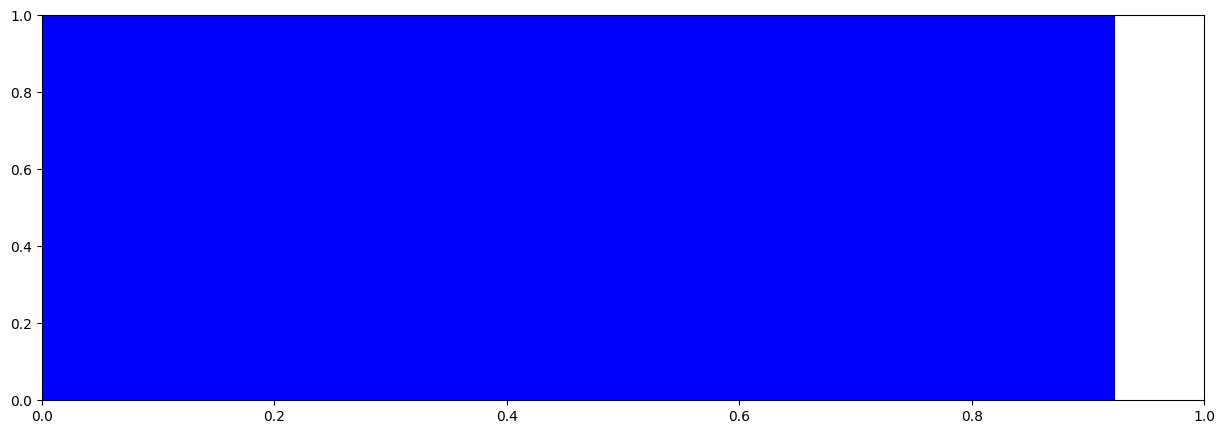

In [4]:
#@title Automation to create 100hrs worth Synthetic Datasets for each Standard Drive Cycle
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Helper functions for augmentation and validation

def detect_pattern(speed_series):
    patterns = []
    for i in range(1, len(speed_series)):
        if speed_series[i] > speed_series[i-1]:
            patterns.append('accelerating')
        elif speed_series[i] < speed_series[i-1]:
            patterns.append('decelerating')
        else:
            patterns.append('idling')
    return patterns

def add_noise_with_limit(speed, patterns, noise_range=3, decimal_places=1):
    synthetic_speed = speed.copy()

    for i in range(len(speed)):
        # If the speed is 0 at any point, keep the speed as 0 in the synthetic dataset
        if speed[i] == 0:
            synthetic_speed[i] = 0
        else:
            # Add noise based on the driving pattern
            if patterns[i-1] == 'accelerating':
                noise = np.round(np.random.uniform(0, noise_range), decimals=decimal_places)
            elif patterns[i-1] == 'decelerating':
                noise = np.round(np.random.uniform(-noise_range, 0), decimals=decimal_places)
            else:
                noise = np.round(np.random.uniform(-1, 1), decimals=decimal_places)  # Less noise during idling

            # Apply the noise
            synthetic_speed[i] += noise

        # Ensure no negative speed values
        if synthetic_speed[i] < 0:
            synthetic_speed[i] = 0

    return synthetic_speed

# Load all standard datasets and calculate total duration
input_folder = '/content/Input'  # Replace with the folder containing all standard datasets
all_files = [f for f in os.listdir(input_folder) if f.endswith('.xlsx')]

total_seconds = 0

if len(all_files) > 0:
    for file_name in all_files:
        file_path = os.path.join(input_folder, file_name)
        data = pd.read_excel(file_path)
        total_seconds += data['Test Time, secs'].iloc[-1]  # Assuming time is cumulative in each file

    total_hours = total_seconds / 3600
    print(f"Total duration of standard datasets: {total_hours:.2f} hours")

    # Calculate number of augmented datasets needed to reach 100 hours
    target_hours = 100
    additional_hours_needed = target_hours - total_hours

    if additional_hours_needed > 0:
        num_augmentations_needed = int(np.ceil(additional_hours_needed / (total_seconds / len(all_files) / 3600)))
        print(f"Number of augmented datasets needed to reach {target_hours} hours: {num_augmentations_needed}")
    else:
        num_augmentations_needed = 0
        print("No additional augmented datasets needed to reach 100 hours.")

    # Augmentation Loop: Generate multiple augmented datasets for each standard dataset
    for file_name in all_files:
        file_path = os.path.join(input_folder, file_name)
        original_data = pd.read_excel(file_path)

        # Extract time and speed columns
        time = original_data['Test Time, secs']
        speed = original_data['Target Speed, mph']

        # Detect patterns of acceleration, deceleration, and idling
        patterns = detect_pattern(speed)

        # Create an output folder for each standard dataset to store its augmented versions
        base_name = os.path.splitext(file_name)[0]
        dataset_output_folder = os.path.join('/content/Output', base_name)
        if not os.path.exists(dataset_output_folder):
            os.makedirs(dataset_output_folder)

        # Define number of augmented datasets to generate
        automated_augmentations = max(num_augmentations_needed, 5)  # Ensure at least 5 augmentations

        for i in range(automated_augmentations):
            # Create synthetic data by adding noise with limit
            synthetic_speed = add_noise_with_limit(speed, patterns)

            # Create augmented data DataFrame
            augmented_data = pd.DataFrame({
                'Test Time, secs': time,
                'Target Speed, mph': synthetic_speed
            })

            # Save the augmented dataset
            augmented_file_name = f'{base_name}_Synthetic_v{i+1}.xlsx'
            augmented_file_path = os.path.join(dataset_output_folder, augmented_file_name)
            augmented_data.to_excel(augmented_file_path, index=False)
            print(f"Augmented dataset saved to {augmented_file_path}")

        # Automated Validation: Compare Standard vs Synthetic Datasets
        validation_results = []

        # Create validation output folders
        validation_folder = '/content/Validation Results'
        histograms_folder = os.path.join(validation_folder, 'Histograms/')
        time_series_folder = os.path.join(validation_folder, 'Time_Series_Plots/')
        metrics_folder = os.path.join(validation_folder, 'Metrics/')

        for folder in [histograms_folder, time_series_folder, metrics_folder]:
            if not os.path.exists(folder):
                os.makedirs(folder)

        # Validate each synthetic dataset
        for i in range(automated_augmentations):
            synthetic_file_path = os.path.join(dataset_output_folder, f'{base_name}_Synthetic_v{i+1}.xlsx')
            synthetic_data = pd.read_excel(synthetic_file_path)
            synthetic_speed = synthetic_data['Target Speed, mph']
            validate_synthetic_dataset(speed, synthetic_speed, time, base_name, i, histograms_folder, time_series_folder, validation_results)

        # Save validation metrics in a CSV file
        metrics_file_path = os.path.join(metrics_folder, f'Validation_Metrics_{base_name}.csv')
        validation_df = pd.DataFrame(validation_results)
        validation_df.to_csv(metrics_file_path, index=False)
        print(f"Validation metrics saved to {metrics_file_path}")

        # Print validation summary for each standard dataset
        for result in validation_results:
            print(f"Validation for {result['Synthetic Dataset']}:")
            print(f"Standard Mean: {result['Standard Mean']:.2f}, Synthetic Mean: {result['Synthetic Mean']:.2f}")
            print(f"Standard Std: {result['Standard Std']:.2f}, Synthetic Std: {result['Synthetic Std']:.2f}")
            print(f"Matching Segments: {result['Matching Segments']}/{result['Total Segments']}")
else:
    print("No standard datasets found in the input folder.")
